# Semantic Segmentation 적용하기

#### 오늘 해볼 것
- 인물 사진 1장 인물모드로 전환
- 고양이 사진 1장 인물모드로 전환
- 각기 다른 사진 2개 합성

- 인물 사진 내 문제점 파악

- semantic segmentation의 단점 보완하는 솔루션 찾기

------------------------------------------------------------

### 1. 인물 사진 '인물모드'로 전환

#### 데이터 불러오기

In [1]:
!pip install pixellib

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# 패키지 불러오기
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(1440, 1080, 3)


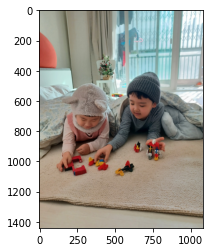

In [3]:
# 사진 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/children.jpeg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
# RGB로 바꿔놓기
img_orig_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

#### segmentation 모델 가져오기

> 이미 가져왔기에 urllib을 통해 pixellib의 모델 가져오는 코드만 참고용으로 붙임
>
>```python
>model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
>model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
>
># PixelLib가 제공하는 모델의 url입니다
>model_url = >'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
>
># 다운로드를 시작합니다
>urllib.request.urlretrieve(model_url, model_file)
>```
>

In [5]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_path = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# segmentation 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_path)

#### segmentation 실행

In [6]:
# 모델에 이미지 입력
segvalues, output_array1 = model.segmentAsPascalvoc(img_path)

In [7]:
segvalues

{'class_ids': array([ 0,  5, 15, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [8]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [9]:
# 어떤 물체들이 탐지됐는지 확인
for int_label in segvalues['class_ids']:
    print(f'int_label: {int_label}, label: {LABEL_NAMES[int_label]}')

int_label: 0, label: background
int_label: 5, label: bottle
int_label: 15, label: person
int_label: 16, label: pottedplant


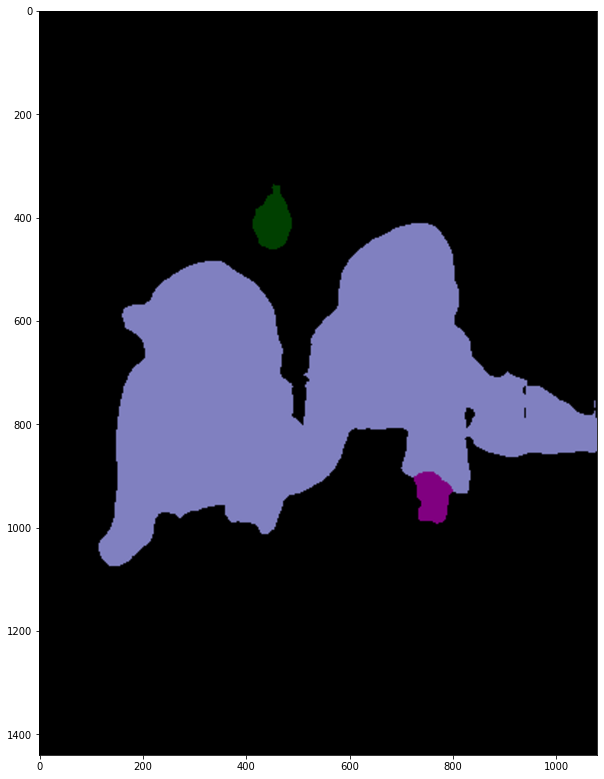

In [10]:
plt.figure(figsize=(10,15))
plt.imshow(output_array1)
plt.show()

> - 예상하지 않았는데, 사진 내 작게 보이는 작은 트리 모형의 물체도 pottedplant로 잡아낸다.  
> - 은근 이런 점은 신기하다.
> - 하지만 딱 봐도 사람이 아닌 이불을 사람으로 착각한 게 보인다.

In [11]:
# label당 색깔 확인
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [12]:
# rgb 순서로 된 컬러맵 생성
rgb_colormap = np.concatenate([colormap[:, 2:], colormap[:, 1:2], colormap[:, 0:1]], axis=1)
rgb_colormap[:20]

array([[  0,   0,   0],
       [  0,   0, 128],
       [  0, 128,   0],
       [  0, 128, 128],
       [128,   0,   0],
       [128,   0, 128],
       [128, 128,   0],
       [128, 128, 128],
       [  0,   0,  64],
       [  0,   0, 192],
       [  0, 128,  64],
       [  0, 128, 192],
       [128,   0,  64],
       [128,   0, 192],
       [128, 128,  64],
       [128, 128, 192],
       [  0,  64,   0],
       [  0,  64, 128],
       [  0, 192,   0],
       [  0, 192, 128]])

> 개인적으로 BGR 순서 같이 일반적인 통념과 다른 개념으로 된 무언가가 있으면, 초기 단계부터 그것을 일반적인 통념과 맞추고 시작하려 한다.

In [13]:
# 확인해보기
rgb_colormap.shape

(256, 3)

In [14]:
# 물체별 컬러RGB 뽑기
for int_label in segvalues['class_ids']:
    print(f'label: {LABEL_NAMES[int_label]}, rgb:{rgb_colormap[int_label]}')

label: background, rgb:[0 0 0]
label: bottle, rgb:[128   0 128]
label: person, rgb:[128 128 192]
label: pottedplant, rgb:[ 0 64  0]


In [15]:
person_color = (128, 128, 192)

(1440, 1080)


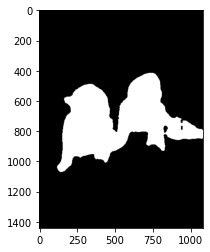

In [16]:
# output_array에서 person_color 마스킹한 어레이 뽑기
person_map = np.all(output_array1==person_color, axis=-1)
print(person_map.shape)
plt.imshow(person_map, cmap='gray')
plt.show()

#### 배경 흐리게 하기

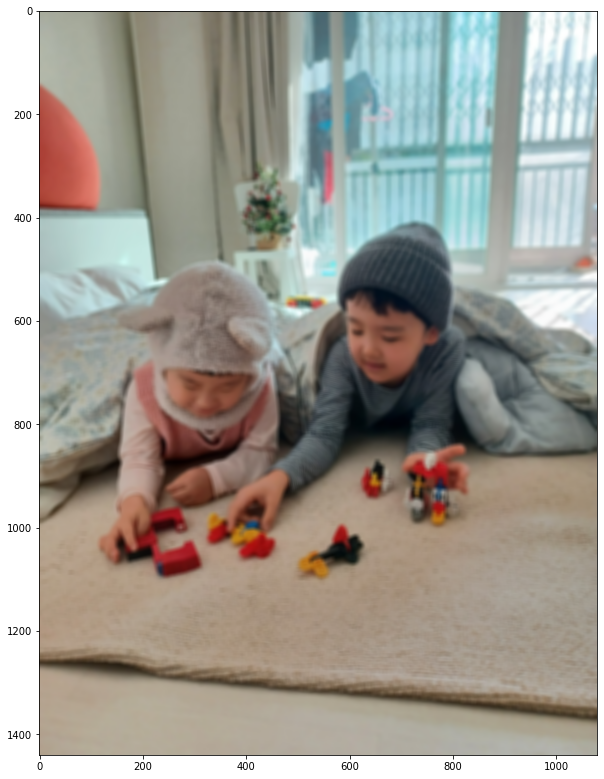

In [17]:
# blur() 함수 이용

img_orig_rgb_blur = cv2.blur(img_orig_rgb, (10,10))
plt.figure(figsize=(10, 15))
plt.imshow(img_orig_rgb_blur)
plt.show()

#### segmentation된 마스크 이용해서 사람만 제외하기

In [18]:
img_mask = person_map.astype(np.uint8) * 255
print(img_mask.shape)

(1440, 1080)


> 위에서
> ```python
> img_mask = person_map * 255
> ```
> 했더니 여기서 오류는 안 나는데 나중에 `cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BRG)`을 할 때 오류가 난다.  
> 사실 나중에 어레이를 봤을 때 0과 255로 이루어지긴 해서 문제 없어보이는데,  
> dtype이 uint8가 아닌 상태였고,  
> 그러면 Unsupported depth of input image: 라고 이유가 뜬다.  
> boolean에 정수를 곱하면 정수같이 보이지만 자료형으로서의 실제 정수와는 다른가 보다.

In [19]:
np.unique(img_mask, return_counts=True)

(array([  0, 255], dtype=uint8), array([1266217,  288983]))

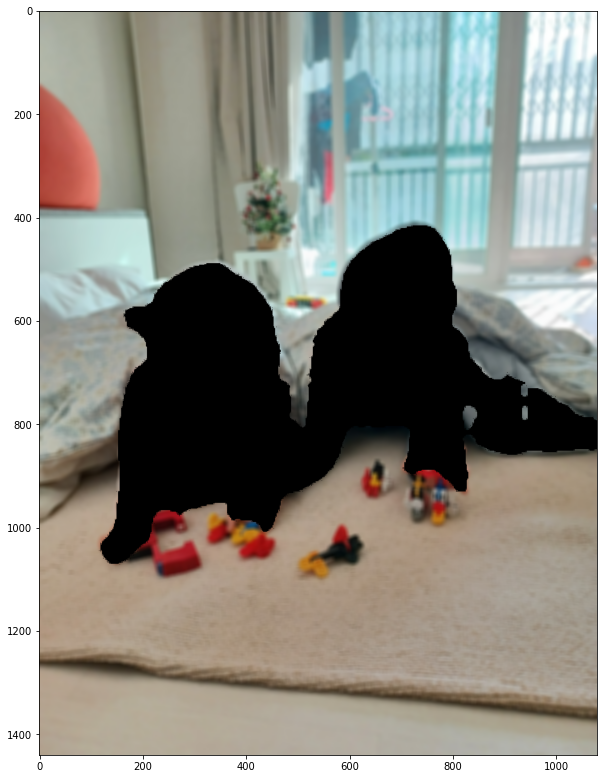

In [20]:
channeled_mask = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2RGB) # 현재 채널이 없는 상태이니 3채널로 바꿔주기
using_mask = cv2.bitwise_not(channeled_mask) # 배경과 사람의 값 바꿔주기
bg_img = cv2.bitwise_and(img_orig_rgb_blur, using_mask) # 공통 부분(배경)만 가져오기
plt.figure(figsize=(10, 15))
plt.imshow(bg_img)
plt.show()

> - 보면 이불 쪽이 같이 제외된 게 보인다.  
> - semantic segmentation의 원리에 비슷한 컬러면 같은 객체로 간주하는 게 있나...?
> - 맞을 경우 그런 부분이 솔루션으로서 개선시켜야 할 부분이 될 수도 있을 것 같다.

#### 합성하기

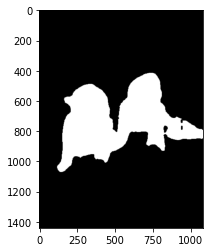

In [21]:
plt.imshow(channeled_mask)
plt.show()

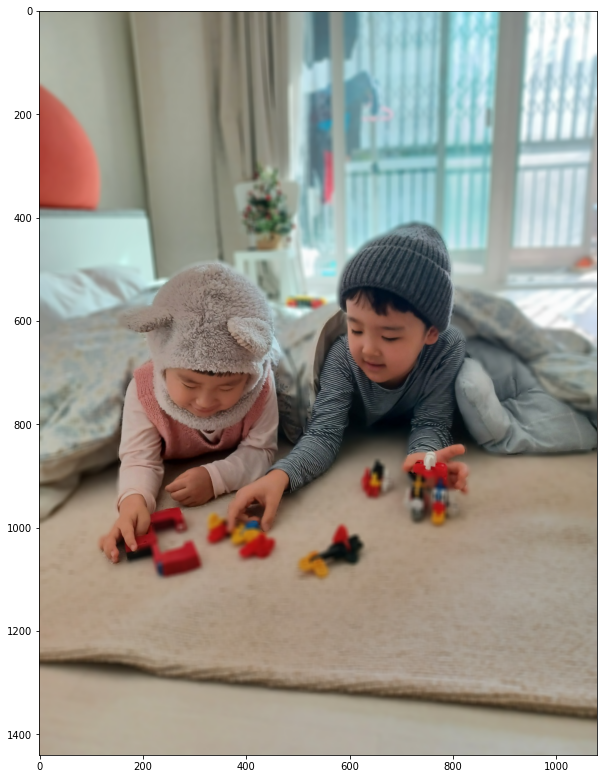

In [22]:
# np.where() 사용해서, 이미지 마스킹 어레이에서 값이 255일 때는 오리지널, 아니면 blurred background 가져오기
img_concat = np.where(channeled_mask==255, img_orig_rgb, bg_img)
plt.figure(figsize=(10, 15))
plt.imshow(img_concat)
plt.show()

In [23]:
# 이미지 저장
cv2.imwrite(os.getenv('HOME')+'/aiffel/human_segmentation/images/children_bg_blurred.jpg',cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

True

## 2. 고양이 사진 '인물모드'로 전환

(493, 980, 3)


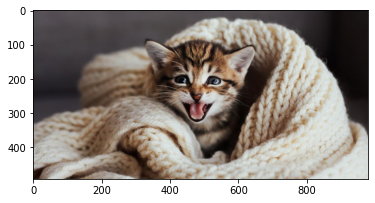

In [24]:
# 사진 불러오기
cat_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpeg'  
cat_orig = cv2.imread(cat_path) 

# RGB로 바꿔놓기
cat_orig_rgb = cv2.cvtColor(cat_orig, cv2.COLOR_BGR2RGB)

print(cat_orig_rgb.shape)
plt.imshow(cat_orig_rgb)
plt.show()

#### sementation 모델 생성 및 실행

In [25]:
# segmentation 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_path)

# 모델에 이미지 입력
segvalues, output_array = model.segmentAsPascalvoc(cat_path)
segvalues

{'class_ids': array([ 0,  8, 18]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [26]:
# 어떤 물체들이 탐지됐는지 확인
for int_label in segvalues['class_ids']:
    print(f'int_label: {int_label}, label: {LABEL_NAMES[int_label]}')

int_label: 0, label: background
int_label: 8, label: cat
int_label: 18, label: sofa


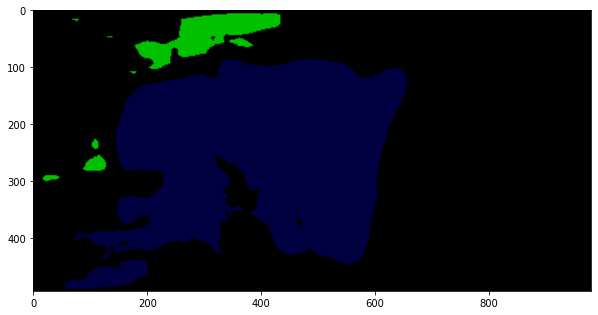

In [27]:
plt.figure(figsize=(10,15))
plt.imshow(output_array)
plt.show()

> - 이것도 고양이 탐지에 부정확하다.
> - 더불어 어떤 부분이 소파로 인식하게 기여했는지 모르겠지만, 고양이 위에 있지도 않은 소파를 탐지해냈다.

In [28]:
# 위의 rgb_colormap 사용
rgb_colormap[8]

array([ 0,  0, 64])

In [29]:
cat_color = (0, 0, 64)

(493, 980)


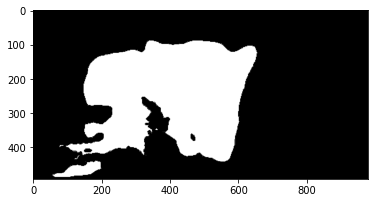

In [30]:
# output_array에서 cat_color 마스킹한 어레이 뽑기
cat_map = np.all(output_array==cat_color, axis=-1)
print(cat_map.shape)
plt.imshow(cat_map, cmap='gray')
plt.show()

> 빛의 영향 때문인지 고양이의 알록달록한 색깔과 목도리의 나름 이것저것 섞인 색깔을 더더욱 구별 못하는 것 같다.

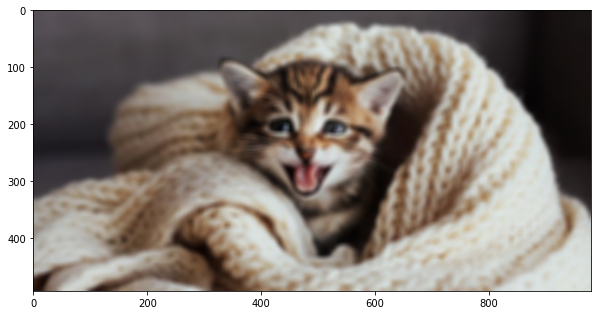

In [31]:
# blur() 함수 이용

cat_orig_rgb_blur = cv2.blur(cat_orig_rgb, (10,10))
plt.figure(figsize=(10, 15))
plt.imshow(cat_orig_rgb_blur)
plt.show()

> 위에서는 중요 부분을 제외한 배경을 `cv2.bitwise_not()` 등을 통해 구하고 그것과 오리지널을 `np.where()`를 통해서 합쳤는데, 중요 부분을 제외한 배경을 따로 구하지 않고 `np.where()`의 조건만 통해서 합치도록 할 예정

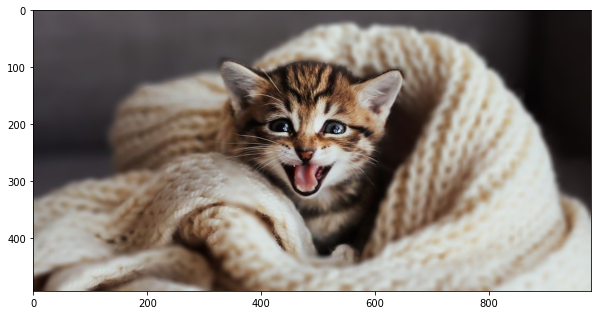

In [32]:
# mask array 값 0~255 스케일 & 정수형으로 바꿔주기
cat_map = cat_map.astype(np.uint8) * 255
cat_map = cv2.cvtColor(cat_map, cv2.COLOR_GRAY2RGB)

# np.where() 조건을 통해 흰 부분(cat)이면 오리지널 가져오기, 아니면 blur 가져오기
merged = np.where(cat_map==255, cat_orig_rgb, cat_orig_rgb_blur)

plt.figure(figsize=(10, 8))
plt.imshow(merged)
plt.show()

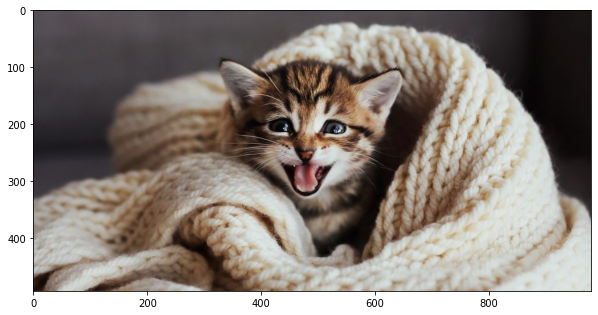

In [33]:
# 원본과 비교
plt.figure(figsize=(10, 8))
plt.imshow(cat_orig_rgb)
plt.show()

## 3. 마스킹을 통해 배경 합성하기

background shape:(720, 1280, 3)
walking shape:(1440, 1080, 3)


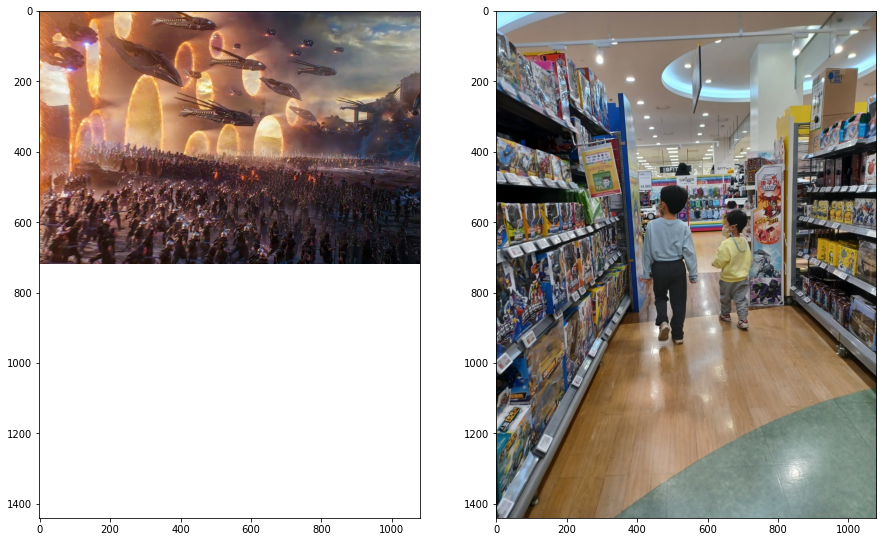

In [34]:
# 사진 불러오기
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.jpeg'  
bg_orig = cv2.imread(bg_path) 
walking_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/walking.jpeg'  
walking_orig = cv2.imread(walking_path) 


# RGB로 바꿔놓기
bg_orig_rgb = cv2.cvtColor(bg_orig, cv2.COLOR_BGR2RGB)
walking_orig_rgb = cv2.cvtColor(walking_orig, cv2.COLOR_BGR2RGB)

print(f'background shape:{bg_orig_rgb.shape}')
print(f'walking shape:{walking_orig_rgb.shape}')
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot(121)
plt.imshow(bg_orig_rgb)

ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
plt.imshow(walking_orig_rgb)

plt.show()

> - `np.where()`에 들어가는 x, y는 broadcastable 해야 한다고 알고 있는데, 두 이미지의 사이즈가 서로 다르다.  
> - walking 그림이 좀 더 크지만, 세로를 줄여서 background 이미지에 맞추고,  
> - background의 가로는 좀 더 기니까 walking 가로에 맞게 resize 할 예정이다.  
>  
>  **합성 목표는 어벤저스를 도와주는 아기들 만들기**

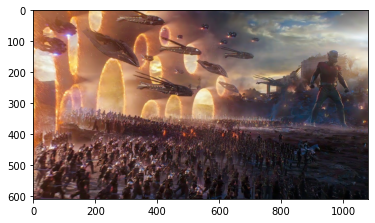

(608, 1080, 3)


In [35]:
# resize 및 crop 하기
# 1) background
scale_down_ratio = walking_orig_rgb.shape[1] / bg_orig_rgb.shape[1]

bg_scaled_rgb = cv2.resize(bg_orig_rgb, None, fx=scale_down_ratio, fy=scale_down_ratio)
plt.imshow(bg_scaled_rgb)
plt.show()

print(bg_scaled_rgb.shape)

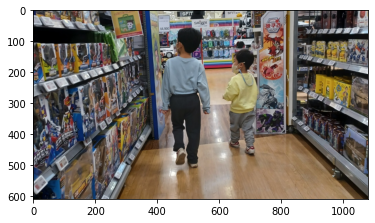

(608, 1080, 3)


In [36]:
# 2) walking 중요 부분만 crop해서 background 높이 크기에 맞추기
# 먼저 크롭할 부분 예측하기
test_area = walking_orig_rgb[440:440+608, :, :]
plt.imshow(test_area)
plt.show()
print(test_area.shape)

In [37]:
# crop하기
walking_cropped_rgb = walking_orig_rgb[440:440+608, :, :]
walking_cropped_rgb.shape

(608, 1080, 3)

#### segmentation으로 사람 마스킹하기

> segmentation 하려니 path를 인자값으로 넣어줘야 해서 해당 이미지를 다시 저장해야겠다.

In [38]:
# 이미지 저장
cv2.imwrite(os.getenv('HOME')+'/aiffel/human_segmentation/images/walking_cropped.jpg',cv2.cvtColor(walking_cropped_rgb, cv2.COLOR_BGR2RGB))

True

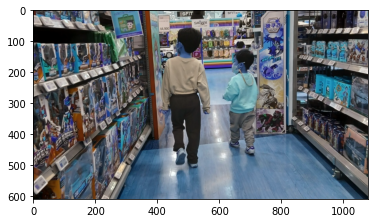

(608, 1080, 3)


In [39]:
# 이미지 확인
walking_crop_path = os.getenv("HOME") + '/aiffel/human_segmentation/images/walking_cropped.jpg'
walking_cropped = cv2.imread(walking_crop_path)

plt.imshow(walking_cropped)
plt.show()
print(walking_cropped.shape)

In [40]:
# segmentation 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_path)

# 모델에 이미지 입력
segvalues, output_array = model.segmentAsPascalvoc(walking_crop_path)
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [41]:
# 어떤 물체들이 탐지됐는지 확인
for int_label in segvalues['class_ids']:
    print(f'int_label: {int_label}, label: {LABEL_NAMES[int_label]}')

int_label: 0, label: background
int_label: 15, label: person


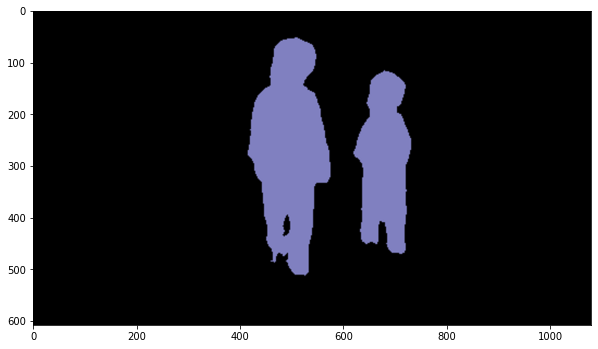

In [42]:
plt.figure(figsize=(10,15))
plt.imshow(output_array)
plt.show()

In [43]:
# person_color 다시 확인하기
# 이거는 RGB 순서였다
person_color

(128, 128, 192)

(608, 1080)


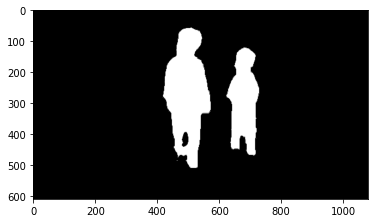

In [44]:
# output_array에서 person_color 마스킹한 어레이 뽑기
walking_map = np.all(output_array==person_color, axis=-1)
print(walking_map.shape)
plt.imshow(walking_map, cmap='gray')
plt.show()

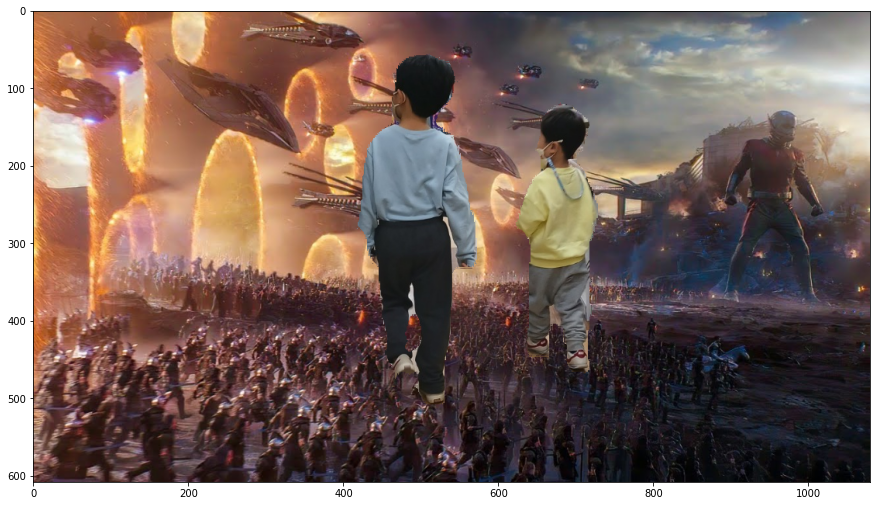

In [45]:
# mask 정수형으로 바꾸고 채널 늘려주기
walking_map = walking_map.astype(np.uint8) * 255
walking_map = cv2.cvtColor(walking_map, cv2.COLOR_GRAY2RGB)

# 마스킹을 이용한 합성
avengers = np.where(walking_map==255, walking_cropped_rgb, bg_scaled_rgb)

plt.figure(figsize=(15,12))
plt.imshow(avengers)
plt.show()

In [46]:
# 이미지 저장
avengers_path = os.getenv("HOME") + '/aiffel/human_segmentation/images/avengers_assembled.jpg'
cv2.imwrite(avengers_path, cv2.cvtColor(avengers, cv2.COLOR_BGR2RGB))

True

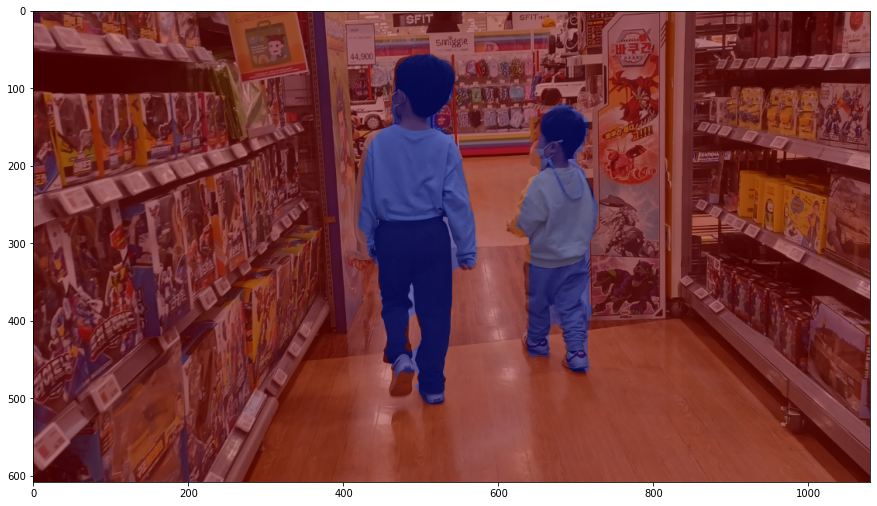

In [47]:
# 마스킹 잘 안 된 부분 파악
walking_copy = walking_cropped_rgb.copy()
color_mask = cv2.applyColorMap(walking_map, cv2.COLORMAP_JET)

investigation = cv2.addWeighted(walking_copy, 0.5, color_mask, 0.5, 0)

plt.figure(figsize=(15, 12))
plt.imshow(investigation)
plt.show()

> - 이번 사진에서는 사람 segmentation에서 잘린 부분이 은근 많다.  
> - 특히 정면을 바라보지 않는 사람의 경우 boundary 부분에서 잘리는 게 많은 것 같다.
> - 위에 사용한 사진들 말고, 실습 시 사용한 사진에 segmentation이 잘 안 된 부분 annotation한 사진을 첨부해보자.(segmentation 관련 새로운 한계점이 있었다.)

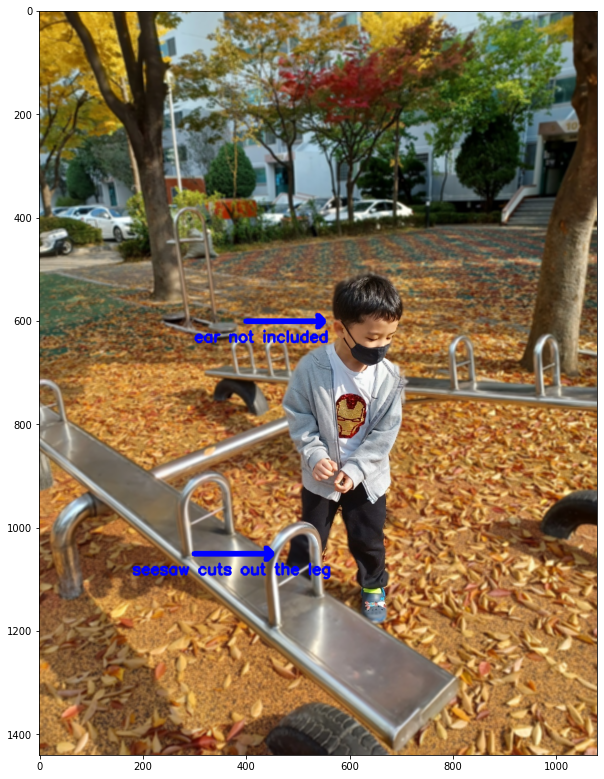

In [48]:
# 프로젝트 전 학습 시 masking 잘 안 된 부분에 annotation 추가한 이미지 불러오기
annotated_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/annotated_eden.png'
annotated = cv2.imread(annotated_path)
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 14))
plt.imshow(annotated_rgb)
plt.show()

> 해당 이미지에서는 특별히 아래와 같은 부분이 잘 segmentation 되지 않았다.
> 1. 동그란 귀부분이 제외됨
> 2. 시소로 인해 연결성이 없어진 다리 부분은 제외됨
>   - 특히 이 부분의 원인을 찾아보자면 시소로 인해 다리 부분에 연결성이 없어졌고, 추측으로는 이미지 내 시소의 두께가 좀 두꺼워서 더 segmentation 시 밑 다리 부분을 제외하지 않았나 싶다.

# 문제점 및 솔루션 제시

#### 정의하는 문제점
- 특정 조건 시 segmentation의 정확성이 낮아진다.
- 특히, 이번 프로젝트 내에서 직접 겪은 바로는 segmentation되어야 할 물체와 비슷한 색상, 혹은 비슷한 texture 같이 보이는 pixel이 옆에 있으면 그것 또한 segmentation하는 경향을 보였다.

> 아래를 통해 내가 생각한 문제가 맞는지 확인해보자

(1440, 1080, 3)


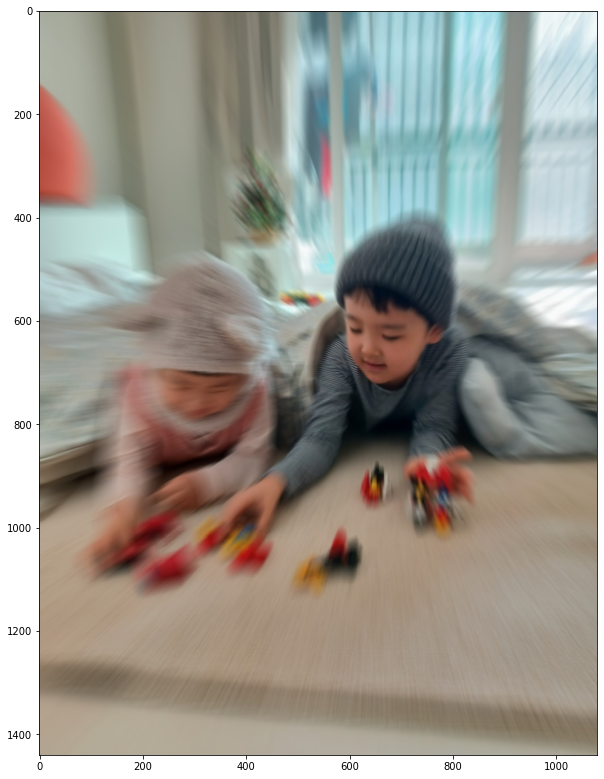

In [49]:
# 테스트용 사진 불러오기 및 segmentation 진행
# 중심으로부터 blur되는 효과를 통해 일부러 더 사람과 주변 사물들 간 색깔 및 빛 차이를 혼란스럽게 해보았다.
# 과연 어떻게 segmentation하는지 보자

# 사진 불러오기
test_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/children_test.jpg'  
test_orig = cv2.imread(test_path) 

# RGB로 바꿔놓기
test_orig_rgb = cv2.cvtColor(test_orig, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,15))
print(test_orig_rgb.shape)
plt.imshow(test_orig_rgb)
plt.show()

int_label: 0, label: background
int_label: 7, label: car
int_label: 15, label: person


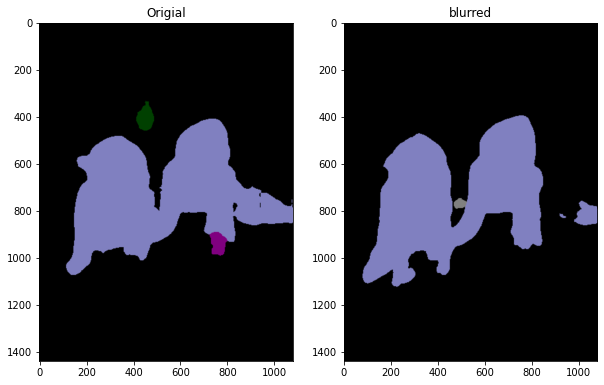

In [50]:
# segmentation 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_path)

# 모델에 이미지 입력
segvalues, output_array = model.segmentAsPascalvoc(test_path)

# 어떤 물체들이 탐지됐는지 확인
for int_label in segvalues['class_ids']:
    print(f'int_label: {int_label}, label: {LABEL_NAMES[int_label]}')
    
    
plt.figure(figsize=(10,15))
plt.subplot(1,2,1)
plt.imshow(output_array1)
plt.title('Origial')
plt.subplot(1,2,2)
plt.title('blurred')
plt.imshow(output_array)
plt.show()

> - 어째 더 segmentation이 잘됐다.  
> - 생각해보니 어쩜 컴퓨터 입장에서는 특정 객체를 중심으로 blur 처리한 것이니 그 객체 segmentation의 경우 이전보다 더 boundary 차이가 극명하게다고 볼 수도 있겠다...  
> - 그런데, 중심에서 약간 벗어난 사람의 경우 그 boundary가 기존보다 더 명확해지지 않았다.
> - 더불어 기존에는 탐색되지 않았던 car 물체도 탐색됐는데, 그것은 잘못된 탐색이다.
> - 즉, 중심 객체를 제외하고 blur처리된 나머지 부분들은 boundary가 sharp하지 않고, sementation 실패가 많아진다. 

(1440, 1080, 3)


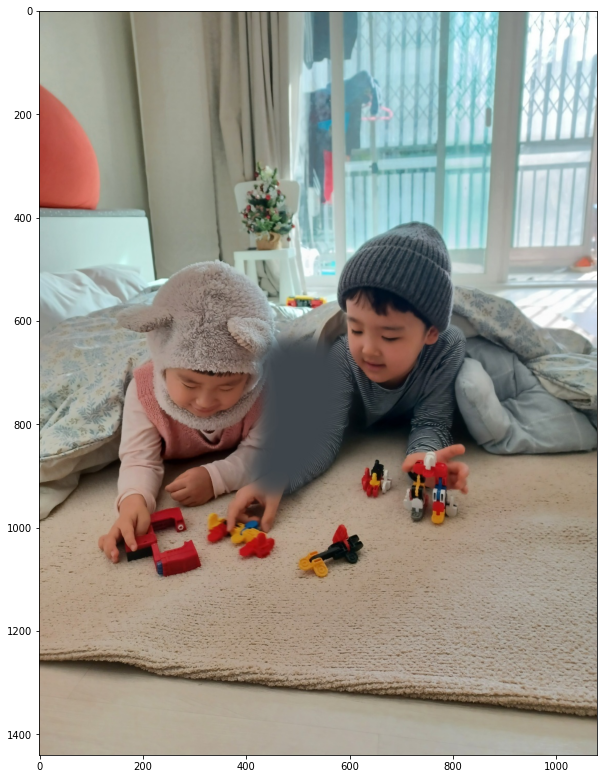

In [51]:
# 그렇다면 그냥 특정 사람과 비슷한 색깔을 그 옆에 연이어서 칠해놓으면 어떻게 될까?
# 허접하지만 두 사람 사이에 paint칠해보자.

# 사진 불러오기
test2_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/children_test2.jpg'  
test2_orig = cv2.imread(test2_path) 

# RGB로 바꿔놓기
test2_orig_rgb = cv2.cvtColor(test2_orig, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,15))
print(test2_orig_rgb.shape)
plt.imshow(test2_orig_rgb)
plt.show()

int_label: 0, label: background
int_label: 5, label: bottle
int_label: 15, label: person
int_label: 16, label: pottedplant


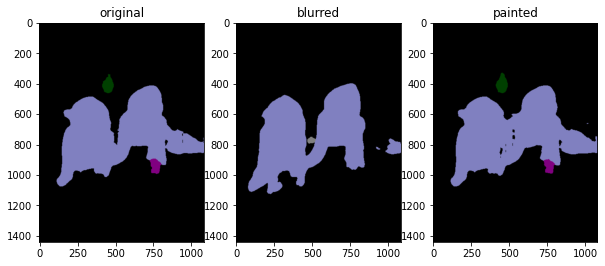

In [52]:
# segmentation 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_path)

# 모델에 이미지 입력
segvalues, output_array2 = model.segmentAsPascalvoc(test2_path)

# 어떤 물체들이 탐지됐는지 확인
for int_label in segvalues['class_ids']:
    print(f'int_label: {int_label}, label: {LABEL_NAMES[int_label]}')
    
    
plt.figure(figsize=(10,18))
plt.subplot(1,3,1)
plt.title('original')
plt.imshow(output_array1)
plt.subplot(1,3,2)
plt.title('blurred')
plt.imshow(output_array)
plt.subplot(1,3,3)
plt.title('painted')
plt.imshow(output_array2)
plt.show()

> - 당연한 것이지만, paint된 두 사람의 사이는 boundary가 불명확하게 segmentation되었다.(연결된 채로 segmentation되었다.)  
> - 그리고 주목할 점은 해당 부분도 'person'으로서 segmentation되었다는 것이다.  

### 결론적으로
> - segmentation은 numerical하게 표현되는 색의 값에 영향을 받으며 
> - 그 데이터의 인접성(?)도 영향을 주는 것 같다

-------------------------------------------------
> 위의 '정의하는 문제점'에 이어서 원인 및 해결책을 제시한다.

#### 기술의 이해
- 문제점에 대한 해결책을 내놓으려면 그것의 원인을 알아야 한다.
- 그리고 그 원인은 기술을 이해함에서 비롯된다.
- 오늘 사용한 Semantic Segmentation 모델은 Deeplabv3+이다.
- 이 모델은 Deeplab 계열의 모델로서 1, 2, 3을 거쳐 진화한 모델인데, 부족하게나마 찾아본 것을 나름 요약해서 설명하자면,
  - 좀 더 개선된 encoder-decoder 모델을 통해 보다 풍부한 정보가 encoding되고, decoding 될 때는 컴퓨터 연산에 있어 보다 효율적인 방법을 통해 물체의 윤곽선을 더 뚜렷하게 구분하게끔 해준다.
    - encoder에는 Atrous Convolutional Layer를 통해 기존보다 더 효율적으로 풍부한 이미지 정보를 획득하고,  
    - decoder에서는 encoding 시 4배 upsample된 feature가 그와 상응하는 low-level feature와 concatenate하게 된다.
    - 이외에 (이해하기로는,) depthwise colvolution과 pointwise convolution이 atrous convolution과 엮이며 창출하는 depthwise astrous seperable convolution이 컴퓨터 연산량 효율성 증가에 막대한 영향을 끼쳤다.


#### 원인
- 사실 요약은 했지만, 정확하게 어떤 부분에서 부정확성이 일어나는지 구체적으로 파악되지는 않는다.
- 다만, 몇 편의 논문과 여러 블로그를 통해 개인적으로 느낀 Semantic Segmentation에서 궁극적으로 필요한 기술, 혹은 개념은(Portrait-mode 만들기에 제한될 수도 있지만,)
- 바로 '사진 속 `Depth`를 numerical data로서 어떻게 표현할 것이냐'는 것이다.

#### 해결책
- 해결책은 주로 두 분류로 나뉘는 것 같다.
- 하드웨어 측면에서의 개선과 소프트웨어 측면에서의 개선.
- 그리고 딥러닝 연구원들은 보다 효율적인 컴퓨터 연산과 혁신적인 모델링을 통해 이를 소프트웨어 측면에서 해결하려는 것으로 보인다.
- 그런데 개인적으로는 `하드웨어 측면에서의 개선`이 이 문제를 더 쉽게 해결할 수 있을 것으로 생각한다.
- 즉, 내가 공감하고, 제안하려는 방향은 `uDepth와 흡사한 방법인데, 촬영 당시 depth 정보가 담긴 사진 한 장을 더 찍게 하는 것`이다.
  - uDepth는 적외선 탐지(?) 센서가 카메라 렌즈 부분에 같이 달려 있다.
  - 그리고 이를 통해 물체들이 적외선으로 구분된 guide 이미지를 한 장 더 추출해낼 수 있는데,
  - 이 guide 이미지는 추후 segmentation할 때 depth 구분상 큰 도움을 준다.
  - 다시 말해, 기존에 색깔로만 표현되던 2D 이미지 데이터에 depth filter가 담긴 동일한 이미지를 한 장 더 얹는 것처럼 해서 segmentation의 정확성을 높이는 것이다.
  - 그리고 다른 사물에 비해 비교적 높은 온도를 내뿜고, segmentation의 주된 대상으로 활용되는 사람은 segmentation이 훨씬 더 용이해진다.
  - 비록 이 기술은 카메라마다 모두 다 저러한 기술을 탑재해야 한다는 단점으로 이어질 수 있지만, Rich Sutton이 얘기한 `The Bitter Lesson`의 교훈처럼 segmentation 기술의 도약에는 소프트웨어 측면의 어려운 연구보다는 훨씬 더 빠르게 문제를 해결할 수 있지 않을까 생각한다.

#### 참고 자료

- (1)https://arxiv.org/abs/1802.02611
- (2)https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html
- (3)https://noteforstudy.tistory.com/entry/DeepLabv3-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0

# 회고

#### Point 1) 기술의 이해를 위한 노력
- 사실 머신러닝 관련 논문 읽기 및 이해는 아이펠 시작 이후부터 크나큰 나의 목표점 중 하나였다.
- 그래서 위의 참고 자료로서 적어놓은 것들 외에 Fully Convolutional Networks 관련 논문과 다른 블로그를 많이 찾아봤다.
- 비록 완전히 이해하지는 못했지만, 이러한 과정을 통해 조금씩 기술에 대해 이해해간다는 것에 뿌듯함을 느꼈고
- 개인적으로는 배우는 단계이다 보니 이렇게 어려운(?), 혹은 뜬금없이 나오는 고수준의 task 같은 게 반갑게 느껴졌다.
- 하지만, 위에 적은 것처럼 아직 기술을 온전히 이해한 게 아니다 보니, 그러한 부분은 나의 숙제로 남기고 있다.
- 앞으로 몇 주 후부터는 주도적으로 최신 논문들을 읽으며 기술의 목적과 어떠한 수학적 원리로 그것을 만들어내는지 연습해갈 예정이다.

#### Poin 2) 완성도 있는 기술
- 저번에 `카메라 스티커 앱 만들기` 편을 이어 두번째로 OpenCV를 이용한 exploration이다.
- 저번에는 단순히 이것저것 실험해보는 식으로 마쳤었는데, 현 시점에서는 정말로 `이러한 기술들을 이용해서 상용화된 제품을 어떻게 만들 수 있을까?`하는 궁금증이 들기 시작한다.
- 아마도 웹 개발 관련한 지식도 있어야 하고, 내가 모르는 많은 부분을 엮어야지 그렇게 하나가 탄생할 수 있을 것이다.
- 앞으로 exploration을 하면서 해당 노드 내의 배움에도 충실하지만, 그 외적으로 더 엮여져야 할 기술에 대해서도 관심을 줘보려 한다.